### Todo
- Graphen hübsch machen
- Betweenness
- Standardabweichungen berechnen wo es interessant sein könnte.
- Logger für Analyseergebnisse?

### Mögliche Tools:
- CoreNLP leider nicht da Java
- SpaCy: Fokus aus Production
- NLTK: python, scheinbar guter "Fokus" auf Bildung.
  - package punkt_tab fürs tokenizing runtergeladen
  - package "stopwords" aus nltk.corpora heruntergeladen. Insgesamt 232 für DE.
- simplemma.lemmatize passt Groß- & Kleinschreibung für uns automatisch an. D.h. wir brauchen scheinbar kein explizites .lower()
- string.punctuation liefert !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 
  - können wir zum entfernen nach tokennizen & lemmatizen verwenden.
- deutscher POS Tagger:
  - https://textmining.wp.hs-hannover.de/Preprocessing.html gibts hier bzw:
  https://serwiss.bib.hs-hannover.de/frontdoor/index/index/docId/1527 \ und hier https://github.com/wartaal/HanTa 
  - Erklärung der Tags: https://homepage.ruhr-uni-bochum.de/stephen.berman/Korpuslinguistik/Tagsets-STTS.html

### Backend Notizen
- Anzahl der Jobs hat bei mir hauptsächlich Einfluss auf RAM Verbrauch. (CPU Last steigt von 4 auf 8 jobs nicht nenneswert. RAM Verbrauch von 4gb auf 9gb)


### Resultate
- Bundesregierung.xml einfaches parsen ergibt: 
  - nodes: 133467 edges: 1343521
  - mean degree: 20.132632036383526
  - median degree: 2.0
  - diameter wurde schon nicht mehr (aufm Laptop) in anständiger Zeit berechnet. (5 Minuten)
- Bundesregierung.xml mit lemmatize und greedy:
  - nodes: 93913 edges: 1007780
  - mean degree: 21.46199141758862
  - median degree: 2.0
  -clustering jetzt 16 Minuten (aufm Laptop) laufen lassen ohne Resultat.
- Bundesregierung mit lemmatize, removeStopwords, removePunctuation, libary tokenizer:
  - nodes: 98774 edges: 1379927
  - mean degree: 27.941097859760667
  - median degree: 2.0
- Bundesregierung mit lemmatize, stopword, punctuation, isalpha() check und libary tokenizer:
  - nodes: 85815 edges: 1333270
  - mean degree: 31.0731224144963
  - median degree: 4.0
  - der isalpha() Check scheint auf jeden Fall ne Menge Mist raus zu werfen. (-13k Einträge)
- Bundesregierung mit allem da oben und Nomen & Namen Filter nach 30 Minuten abgebrochen. (Laptop)
- Bundesregierung um 12:55 gestartet mit parallel = 2, hatte nach 20 Minuten allen RAM gefressen und Rechner gecrasht (>10gb)

##### Beispieltext TEXT
- Einfaches parsen ohne lemmatize 
  - len(text) = 126 
  - nodes: 93 edges: 117
- parsen mit lemmatize, greedy = False
  - len(text) = 126, wie erwartet.
  - nodes: 83 edges: 111
- parsen mit lemmatzie, greedy = True
   - nodes: 83 edges: 111 d.h. unverändert.
- parsen mit nltk tokenizer, lemmatize, stopwords und punctuation removed
  - nodes: 64, edges: 86
-parsen mit nltk tokenizer, lemmatize, stopwords & punctuatin removed & isalpha() check:
  - nodes: 57, edges: 61


In [3]:
import string
import simplemma
import networkx as nx
import nx_parallel as nxp
import numpy as np
import nltk
import matplotlib.pyplot as plt
from HanTa import HanoverTagger as ht
import scipy


# enabling networkx's config for nx-parallel
nx.config.backends.parallel.active = True

# setting `n_jobs` (by default, `n_jobs=None`)
nx.config.backends.parallel.n_jobs = 8

TAGGER_DE = ht.HanoverTagger('morphmodel_ger.pgz') #for POS Tagging
TAGGER_EN = ht.HanoverTagger('morphmodel_en.pgz')

TEXT = """
Meine Als Damen und Herren, als am 1. September 1948 in Bonn die 65 von den damals gerade gewählten Landtagen der elf Bundesländer bestellten Mitglieder des parlamentarischen Rates zusammentraten, 61 Männer und ganze 4 Frauen, auch da hat sich manches in diesen Jahrzehnten weiterentwickelt, um dem nichtsouveränen, unter der Kontrolle alliierter Besatzungsmächte stehenden westlichen Teil Deutschland eine gemeinsame vorläufige Verfassung zu geben, wurde in einer damals kaum vorhersehbaren, von vielen auch schlicht nicht für möglich gehaltenen nachhaltigen Weise die Grundlage der Bundesrepublik Deutschland gelegt, deren 60. Geburtstag wir in diesem Jahr begehen können. Heute wissen wir, dass mit der Konstituierung des Parlamentarischen Rates gleich drei präjudizierende Entscheidungen verbunden waren: Die Entscheidung für einen Standort, die Entscheidung für eine Persönlichkeit und die Entscheidung für ein Konzept.
Die Entscheidung für Bonn als Standort, für Konrad
"""
WHITELIST = string.ascii_lowercase + "äüöß "

## Verarbeitung

In [4]:
#erster Anlauf ohne "ausgiebige" Nutzung anderer Module außer dem Lemmatizer.
#greedy=stronger reduction, might be closer to stemming (Wörter auf Wortstamm) than lemmatization (Flexation -> Grundform)
def prepareText(text, lemmatize=True, greedy=False):
    text = text.replace("\n", " ").strip().lower()
    text = "".join([c for c in text if c in WHITELIST])
    text = [word for word in text.split(" ") if len(word) > 0]
    if lemmatize:
        text = [ simplemma.lemmatize(token, lang='de', greedy=greedy) for token in text ]
    print(text)
    return text

def textToGraph(preparedText: list):
    graph = nx.Graph()
    graph.add_nodes_from(preparedText)
    for i in range(len(preparedText)-1):
        graph.add_edge(preparedText[i], preparedText[i+1])
    return graph

#### Zweiter Anlauf mit Modulnutzung für stopwords, tokenizing, lemmatizing

####Allgemeine, zusammenfassende Methoden
def prepareTextWithLibaries(text: str, filterNouns=False, removeStopwords=True, language="de") -> list[str]:
    t = tokenize(text, language=language)
    t = filterTokens(lemmatize(t, language=language), removeStopwords=removeStopwords)
    if filterNouns:
        t = filterNounsAndNames(t)
    return t

def fileToGraph(filename, graph, filterNouns=False, removeStopwords=False, language="de"):
    totalTokens = 0
    with open(filename) as file:
        lastToken = None
        for line in file:
            tokens = prepareTextWithLibaries(line, filterNouns=filterNouns, removeStopwords=removeStopwords, language=language)
            # we have to remember the last token per line to connect with first token of next line
            if len(tokens) > 0:
                if lastToken != None:
                    graph.add_edge(lastToken, tokens[0])
                lastToken = tokens[-1]
                totalTokens = totalTokens + len(tokens)
            for i in range(len(tokens)-1):
                graph.add_edge(tokens[i], tokens[i+1])
    print(str.format("processed {0} tokens in total. Resulting graph has {1} nodes and {2} edges.", totalTokens, len(graph.nodes), len(graph.edges)))
    return graph

#removes stopwords, punctuation, and every non alphabetic token
def filterTokens(text: list, removeStopwords=False, language="de") -> list[str]:
    punctuation = set(string.punctuation)
    if not removeStopwords:
        return [ word for word in text if word.isalpha() and word not in punctuation ]
    stop = getStopwords(language)
    stopAndPunctuation = stop.union(punctuation)
    return [ word for word in text if word.isalpha() and word not in stopAndPunctuation ]

def lemmatize(text: list, greedy=True, language="de"):
    return [ simplemma.lemmatize(token, lang=language, greedy=greedy) for token in text ]

#### Hilfsmethoden
def tokenize(text: str, language="de"):
    if language == "de":
        lang = "german"
    elif language == "en":
        lang = "english"
    else:
        raise ValueError("language must be de or en")
    return nltk.word_tokenize(text, language=lang)

def getStopwords(language):
    if language == "de":
        return set(nltk.corpus.stopwords.words("german"))
    elif language == "en":
        return set(nltk.corpus.stopwords.words("english"))
    else:
        raise ValueError("language must be de or en")

def removeStopwords(text: list, language="de"):
    stop = getStopwords(language)
    return [ word for word in text if word not in stop ]

def removePunctuation(text: list):
    punctuation = string.punctuation
    return [word for word in text if word not in punctuation ]

def removeNonAlphabetToken(text: list):
    return [ word for word in text if word.isalpha() ]

def filterNounsAndNames(token : list[str], language="de"):
    keepTags = [ "NN", "NE" ] #NN = Noun, NE = Name
    return [ word for word in token if any(tag in getTags(word, language=language) for tag in keepTags) ]

#Tagger sollte aus Performancegründen nicht mit jedem Aufruf geladen werden. Daher global.
def getTags(word, language="de"):
    if language == "de":
        tagger = TAGGER_DE
    elif language == "en":
        tagger = TAGGER_EN
    else:
        raise ValueError("language must be de or en")
    return [ res[0] for res in tagger.tag_word(word) ] #res[0] = tag, res[1] = propability




## Analyse

In [5]:
def analyzeGraph(graph, parallel=False):
    print(str.format("nodes: {0} edges: {1}", len(graph.nodes), len(graph.edges)))
    degrees = np.array([ deg for node, deg in graph.degree ])
    print(str.format("mean degree: {0}", np.mean(degrees)))
    print(str.format("median degree: {0}", np.median(degrees)))
    if parallel:
        parallelResults = parallelGetDistanceMeasures(graph)
        print(str.format("diameter: {0}", parallelResults["diameter"]))
        print(str.format("average distance: {0}", parallelResults["avgDistance"]))
    else:
        print(str.format("diameter: {0}", nx.diameter(graph)))
        print(str.format("avg. distance: {0}", nx.average_shortest_path_length(graph)))
    betweennessRes = getBetweennessMeasures(graph, parallel=parallel)
    print(str.format("avg. betweenness: {0}, max betweenness: {1}, standard deviation: {2}", 
                     betweennessRes["avg"], betweennessRes["max"], betweennessRes["std"]))
    print(str.format("avg. clustering: {0}", nx.average_clustering(graph))) #no parallel implementation

def parallelGetDistanceMeasures(graph):
    maxDistance = 0
    avgDistance = 0
    for node, lengthDict in nxp.all_pairs_shortest_path_length(graph):
        for k, v in lengthDict.items():
            if k == node: continue
            maxDistance = max(maxDistance, v)
            avgDistance = avgDistance + v #python3 maxint does not have max size, so there shouldnt be an overflow risk.
    nodes = graph.order()
    avgDistance = avgDistance / (nodes * (nodes-1)) #handshake lemma, therefore double-counting of distance is fine.
    return { "diameter" : maxDistance,  "avgDistance" : avgDistance }

#eigentlich ist nur der average interessant. Aber wenn wir schon mal dabei sind..
#vielleicht Standardabweichung? 
def getBetweennessMeasures(graph, parallel=False):
    if parallel:
        betweennessDict = nxp.betweenness_centrality(graph)
    else:
        betweennessDict = nx.betweenness_centrality(graph)
    data = np.array( [val for val in betweennessDict.values()] )
    min = np.min(data)
    max = np.max(data)
    avg = np.mean(data)
    std = np.std(data)
    return { "min": min, "max": max, "avg": avg, "std": std }

def getSortedDegreeList(graph, desc=True):
    return sorted(graph.degree, key=lambda nodeDegreePair : nodeDegreePair[1], reverse=desc) #descending order

def getHighestDegNodes(graph, n):
    return getSortedDegreeList(graph)[0:n] if n <= graph.number_of_nodes() else getSortedDegreeList(graph)

def getLowestDegNodes(graph, n):
    return getSortedDegreeList(graph, desc=False)[0:n] if n <= graph.number_of_nodes() else getSortedDegreeList(graph, desc=False)

def getRawDegreeList(graph):
    return [ nodeDegTuple[1] for nodeDegTuple in graph.degree ]

def getDegProbabilityDict(graph):
    degFrequencyList = np.array(nx.degree_histogram(graph))
    totalNodes = graph.order()
    res = {}
    for deg in range(len(degFrequencyList)):
        if degFrequencyList[deg] == 0: continue
        else:
            res[deg] = degFrequencyList[deg] / totalNodes
    return res






## Visualisierung

In [17]:
#Visualisierung
def degreeDistHist(graph):
    #nx.degree_histogramm könnte sinnvoller sein.
    data = np.array(getRawDegreeList(graph))
    plt.hist(data, bins=100)
    plt.xlabel("Degree")
    plt.ylabel("Number of Nodes")
    plt.grid(True)
    plt.show()

def degreeScatterPlot(graph):
    data = getDegProbabilityDict(graph)

    x = np.array(list(data.keys()), dtype=float)
    y = np.array(list(data.values()), dtype=float)

    degAsLog = np.log10(list(data.keys()))
    degProbAsLog = np.log10(list(data.values()))
    res = scipy.stats.linregress(degAsLog, degProbAsLog)
    slope = res[0]
    intercept = res[1]
    xValsLine = np.logspace(np.log10(min(x)), np.log10(max(x)), 100)
    yValsLine = 10 ** (slope * np.log10(xValsLine) + intercept)
    #print(str.format("xmin: {0} xmax: {1}", min(xValsLine), max(xValsLine)))
    #print(str.format("ymin: {0} ymax: {1}", min(yValsLine), max(yValsLine)))
    plt.plot(xValsLine, yValsLine, color="red")

    plt.scatter(x, y)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("deg")
    plt.ylabel("p(deg)")
    plt.grid(True)
    plt.show()




In [ ]:
#text = prepareText(TEXT,  lemmatize=True, greedy=True)
#print(len(text))
#G = textToGraph(text)
#analyzeGraph(G, parallel=False)
text2 = prepareTextWithLibaries(TEXT, removeStopwords=False)
print(text2)
print(len(text2))
G = textToGraph(text2)
analyzeGraph(G, parallel=False)


['mein', 'als', 'Dame', 'und', 'Herr', 'als', 'am', 'September', 'in', 'Bonn', 'der', 'von', 'der', 'damals', 'gerade', 'gewählt', 'Landtag', 'der', 'elf', 'Bundesland', 'bestellen', 'Mitglied', 'der', 'parlamentarisch', 'Rat', 'zusammentreten', 'Mann', 'und', 'ganz', 'Frau', 'auch', 'da', 'haben', 'mancher', 'in', 'dies', 'Jahrzehnt', 'weiterentwickel', 'um', 'der', 'nichtsouverän', 'unter', 'der', 'Kontrolle', 'alliiert', 'Besatzungsmacht', 'stehend', 'westlich', 'Teil', 'Deutschland', 'ein', 'gemeinsam', 'vorläufig', 'Verfassung', 'zu', 'geben', 'werden', 'in', 'ein', 'damals', 'kaum', 'vorhersehbar', 'von', 'viel', 'auch', 'schlicht', 'nicht', 'für', 'möglich', 'gehalten', 'nachhaltig', 'Weise', 'der', 'Grundlage', 'der', 'Bundesrepublik', 'Deutschland', 'legen', 'der', 'Geburtstag', 'wir', 'in', 'dies', 'Jahr', 'begehen', 'können', 'heute', 'wissen', 'wir', 'dass', 'mit', 'der', 'Konstituierung', 'der', 'parlamentarisch', 'Rat', 'gleich', 'drei', 'präjudizierende', 'Entscheidung',

#### spezifische political speeches Dinge

In [57]:
import xml.etree.ElementTree as ET

def iterateAndProcessDocumentTree(tree, graph):

    root = tree.getroot()

    #count = 0

    for text_elem in root.findall("text"):
        #count = count + 1
        person = text_elem.get("person")
        titel = text_elem.get("titel")
        datum = text_elem.get("datum")
        ort = text_elem.get("ort")
        untertitel = text_elem.get("untertitel")
        url = text_elem.get("untertitel")
        anrede = text_elem.get("anrede")

        rohtext_elem = text_elem.find("rohtext")
        rohtext = rohtext_elem.text if rohtext_elem is not None else ""

        #if count == 1:
        textArr = preprocessRohtextWithLibaries(rohtext)
        #textArr = filterNounsAndNames(textArr)
        addToGraph(textArr, graph)
    return graph #not neccessary but w/e


def preprocessRohtext(rohtext):
    text = prepareText(rohtext, lemmatize=True, greedy=True)
    return text

def preprocessRohtextWithLibaries(rohtext):
    return prepareTextWithLibaries(rohtext, removeStopwords=False)

def addToGraph(text, graph):
    graph.add_nodes_from(text)
    for i in range(len(text)-1):
        graph.add_edge(text[i], text[i+1])

def processDocument(docPath, graph):
    with open(docPath) as file:
        tree = ET.parse(file)
    iterateAndProcessDocumentTree(tree, graph)
    return graph
    



In [58]:
G = nx.Graph()
PATH = "../Daten/Bundesregierung.xml"
res = processDocument(PATH, G)

85924


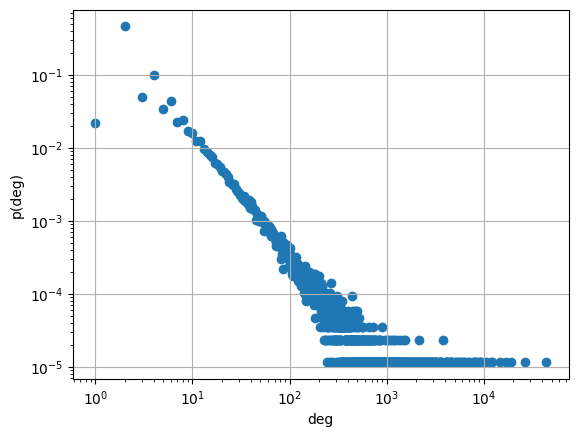

In [59]:
print(G.order()) #85815
#print(getLowestDegNodes(G, 100))
#parralel backenend für diameter etc?
#analyzeGraph(G, parallel=True)
degreeScatterPlot(G)

## Kafka Test
- Buch hat ca. 84.000 Wörter (überschlagen)
- 2do: Beim Englischen werden ~84.000 Token verarbeitet und Graph hat am Ende nur 3300 Knoten. Ist etwas große Differenz finde ich.

**Ergebnis ohne Stopwords**
- ~1s Verarbeitung, 31.000 Tokens verarbeitet
- 5400 Nodes, 27.000 Edges.
- ~50s Analyse, nicht parallel
- ~30s Analyse, parallel
- mean degree: 10.03737971872687
- median degree: 4.0
- diameter: 9
- average distance: 3.3626959444769353
- avg. clustering: 0.09817590698451623

**Ergebnis mit Stopwords**
- ~1s Verarbeitung, 68.000 Tokens verarbeitet
- 5508 Nodes, 33543 Edes
- 57s Analyse, nicht parallel
- 33s Analyse, parallel
- nodes: 5508 edges: 33543
- mean degree: 12.179738562091503
- median degree: 3.0
- diameter: 6
- average distance: 2.7191990678266613
- avg. clustering: 0.4789961888932891


In [7]:
PROZESS_AUSZUG = "../Ressourcen/Daten/Buecher/Kafka/Kafka_Der_Prozess_cleaned_Auszug.txt"
PROZESS_GESAMT_DE = "data/input/Kafka_Prozess_de.txt"
PROZESS_GESAMT_EN = "../Ressourcen/Daten/Buecher/Kafka/Kafka_The_Trial_cleaned.txt"

G = nx.Graph()
fileToGraph(PROZESS_GESAMT_DE, G, filterNouns=False, removeStopwords=True, language="de")

processed 31141 tokens in total. Resulting graph has 5404 nodes and 27121 edges.


In [8]:
analyzeGraph(G, parallel=True)
#degreeScatterPlot(G)
#res = nxp.betweenness_centrality(G)

nodes: 5404 edges: 27121
mean degree: 10.03737971872687
median degree: 4.0
diameter: 9
average distance: 3.3626959444769353
TODO
average betweenness centrality: None
avg. clustering: 0.09817590698451623


In [8]:
AMERIKA_DE = "data/input/Kafka_Amerika_de.txt"
fileToGraph(AMERIKA_DE, G, filterNouns=False, removeStopwords=True, language="de")
#Nur Amerika: processed 41226 tokens in total. Resulting graph has 7005 nodes and 35072 edges.

processed 41226 tokens in total. Resulting graph has 9247 nodes and 59759 edges.


In [9]:

VERWANDLUNG_DE = "data/input/Kafka_Verwandlung_de.txt"
fileToGraph(VERWANDLUNG_DE, G, filterNouns=False, removeStopwords=True, language="de")

processed 9016 tokens in total. Resulting graph has 9828 nodes and 66932 edges.


In [10]:
SCHLOSS_DE = "data/input/Kafka_Schloss_de.txt"
fileToGraph(SCHLOSS_DE, G, filterNouns=False, removeStopwords=True, language="de")

processed 46609 tokens in total. Resulting graph has 12425 nodes and 102077 edges.


In [11]:
analyzeGraph(G, parallel=True)

nodes: 12425 edges: 102077
mean degree: 16.430905432595573
median degree: 4.0
diameter: 9
average distance: 3.165432789913985
avg. betweenness: 0.0001743083627073964, max betweenness: 0.06909074116718551, standard deviation: 0.0013596380762946902
avg. clustering: 0.16014143217825738


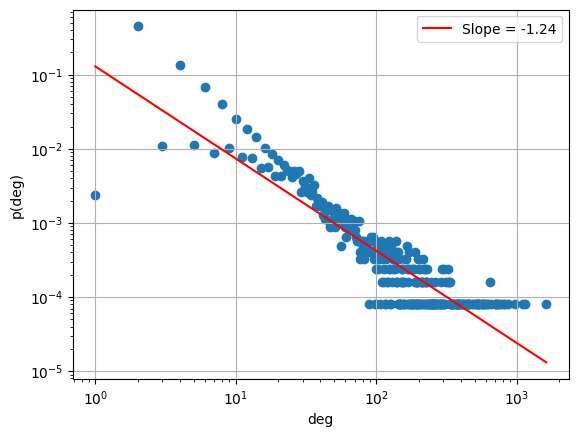

In [16]:
degreeScatterPlot(G)
#degreeDistHist(G)
#analyzeGraph(G, parallel=True)

In [37]:
data = getDegProbabilityDict(G)
degAsLog = np.log10(list(data.keys()))
degProbAsLog = np.log10(list(data.values()))
res = scipy.stats.linregress(degAsLog, degProbAsLog)
print(res)

LinregressResult(slope=np.float64(-1.2445089552846322), intercept=np.float64(-0.8875029538167167), rvalue=np.float64(-0.9024412565928918), pvalue=np.float64(2.684835238779147e-114), stderr=np.float64(0.0339077227480379), intercept_stderr=np.float64(0.07409336901918355))


In [33]:
data = getDegProbabilityDict(G)
data.pop(1)
degAsLog = np.log10(list(data.keys()))
degProbAsLog = np.log10(list(data.values()))
res = scipy.stats.linregress(degAsLog, degProbAsLog)
print(res)


LinregressResult(slope=np.float64(-1.2977390819424677), intercept=np.float64(-0.7681568731691892), rvalue=np.float64(-0.9144082558888368), pvalue=np.float64(3.240955018117018e-122), stderr=np.float64(0.03284125533318951), intercept_stderr=np.float64(0.07187938455858844))


In [34]:
data = getDegProbabilityDict(G)
data.pop(1)
data.pop(2)
degAsLog = np.log10(list(data.keys()))
degProbAsLog = np.log10(list(data.values()))
res = scipy.stats.linregress(degAsLog, degProbAsLog)
print(res)

LinregressResult(slope=np.float64(-1.2751005220935527), intercept=np.float64(-0.8193059792300961), rvalue=np.float64(-0.9102564118370218), pvalue=np.float64(7.933782918383703e-119), stderr=np.float64(0.033210721062688735), intercept_stderr=np.float64(0.07280408345614112))


LinregressResult(slope=np.float64(-1.2445089552846322), intercept=np.float64(-0.8875029538167167), rvalue=np.float64(-0.9024412565928918), pvalue=np.float64(2.684835238779147e-114), stderr=np.float64(0.0339077227480379), intercept_stderr=np.float64(0.07409336901918355))


### Codeanalyse

In [ ]:
### Code Analyse Dinge
import string 
import keyword

kw = keyword.kwlist

def replacePunctuation(code : str):
    punct = string.punctuation
    for p in punct:
        code = code.replace(p, " ")
    return code



G = nx.Graph()

with open("pixel_sort.py", "r") as file:
    total = []
    for line in file:
        if line.startswith("#"): continue
        token = replacePunctuation(line).strip().split(" ")
        #Zahlen entfernen?
        #Kommentare besser entfernen da ggf hinter Code
        token = [ t.lower() for t in token if t]
        total += token
    #print(total)
    total = [t for t in total if t not in kw]
    for i in range(0, len(total)-1):
        G.add_edge(total[i], total[i+1])


In [33]:
analyzeGraph(G)
print(G.nodes)

nodes: 200 edges: 469
mean degree: 4.69
median degree: 2.0
diameter: 7
avg. distance: 3.411507537688442
avg. clustering: 0.1625798425621406
['pixel', 'sorting', 'cv2', 'numpy', 'np', 'math', 'colorsys', 'pandas', 'pd', 'os', 'argparse', 'tqdm', 'sound', 'parser', 'argumentparser', 'you', 'iniatize', 'such', 'add', 'argument', 'f', 'required', 'true', 'help', 'enter', 'filename', 'of', 'your', 'picture', 'args', 'parse', 'take', 'the', 'arguments', 'command', 'line', 'makedirs', 'image', 'sort', 'str', 'print', 'capitalize', 'directory', 'created', 'df', 'total', '0', 'dict', 'final', 'img', 'list', 'createdataset', 'val', 'data', 'len', 'max', 'keys', 'dataframe', 'columns', 'blue', 'green', 'red', 'to', 'excel', 'output', 'xlsx', 'generatecolors', 'c', 'sorted', 'frame', 'row', 'height', '15', 'zeros', '3', 'uint8', 'x', 'range', 'r', 'g', 'b', '255', '1', '2', 'append', 'color', 'value', 'xth', 'column', 'this', 'gives', 'band', 'changes', 'added', 'every', 'measure', 'count', 'col',

In [27]:
print(keyword.kwlist)

['False', 'None', 'True', 'and', 'as', 'assert', 'async', 'await', 'break', 'class', 'continue', 'def', 'del', 'elif', 'else', 'except', 'finally', 'for', 'from', 'global', 'if', 'import', 'in', 'is', 'lambda', 'nonlocal', 'not', 'or', 'pass', 'raise', 'return', 'try', 'while', 'with', 'yield']
